Abstract:

focused on the metadata exclusively. I applied NLP techniques on the title and the abstract of each article to find out information about vaccins and therapeutics.I built LDA and KNN models in order to target articles about vaccine exclusively. Thanks to these 2 models which help  managed to reduce the number of articles from 22000 to 1000 roughly.  

# Set up

import libraries

In [1]:
import gensim
from gensim import corpora, models
from gensim.models import Word2Vec
from multiprocessing import freeze_support

import pyLDAvis.gensim

import nltk
from nltk import stem

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from IPython.display import IFrame
import matplotlib
from matplotlib import pyplot

import pandas as pd
import numpy as np
import json
import os

In [2]:
!pip3 install pyLDAvis

    100% |████████████████████████████████| 1.6MB 310kB/s ta 0:00:011
  Using cached https://files.pythonhosted.org/packages/8c/23/848298cccf8e40f5bbb59009b32848a4c38f4e7f3364297ab3c3e2e2cd14/wheel-0.34.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/22/e7/4b2bdddb99f5f631d8c1de259897c2b7d65dcfcc1e0a6fd17a7f62923500/numpy-1.19.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/2b/a8/f4c66eb529bb252d50e83dbf2909c6502e2f857550f22571ed8556f62d95/scipy-1.5.2-cp36-cp36m-manylinux1_x86_64.whl
    100% |████████████████████████████████| 10.5MB 77kB/s  eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/51/dd/0e015051b4a27ec5a58b02ab774059f3289a94b0906f880a3f9507e74f38/joblib-0.16.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/30/9e/f663a2aa66a09d838042ae1a2c5659828bb9b41ea3a6efa20a20fd92b121/Jinja2-2.11.2-py2.py3-none-any.whl
    100% |████████████████████████████████| 163kB 2.4MB/s 

# Import meta data

In [2]:
#read metadata function
def readMetaData(path):
    metadataDf = pd.read_csv(path, encoding = 'utf-8')
    metadataDf = metadataDf.loc[metadataDf.abstract.str.len() < 1500]
    metadataDf["text"] = metadataDf["title"] + ' ' + metadataDf["abstract"]
    return metadataDf

We import meta data as given for the challenge. Title and Abstract are concatenated in column 'text'. Abstracts with length bigger than 1500 words are removed. That actually concerned one huge article. The article is removed as we try to keep a balanced distribution.

In [3]:
dataDf = readMetaData('/home/niharika/Documents/covid2/2020-04-17/metadata.csv')

# Data exploration

the metadata present the following features

In [4]:
for col in dataDf.columns:
    print(col)

cord_uid
sha
source_x
title
doi
pmcid
pubmed_id
license
abstract
publish_time
authors
journal
Microsoft Academic Paper ID
WHO #Covidence
has_pdf_parse
has_pmc_xml_parse
full_text_file
url
text


check the repartition of publications between sources

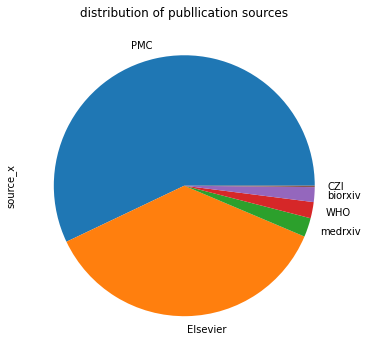

In [5]:
dataDf.source_x.value_counts()\
    .plot(kind = 'pie', title = 'distribution of publlication sources', figsize = (6,6));

check the distribution of publications per year

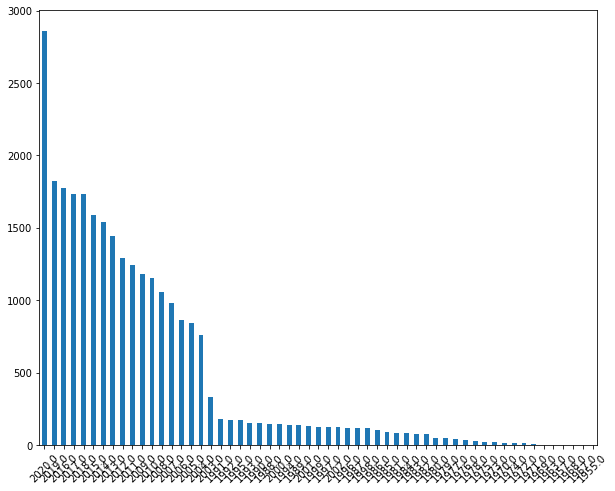

In [6]:
pd.to_datetime(dataDf.publish_time, errors='coerce', format = '%Y/%m/%d')\
    .dt.year.value_counts().plot.bar(x = 'year', rot=45, figsize = (10,8));

check how much articles have their full text available (True)

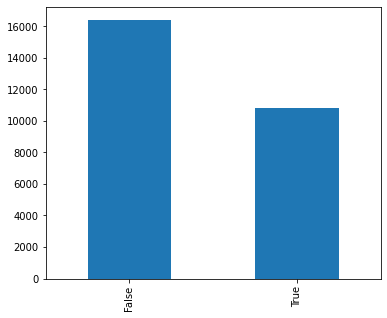

In [7]:
dataDf.has_pmc_xml_parse.value_counts().plot(kind = 'bar', figsize = (6,5));

each article comes with a title. Below is the overall distribution of the length of the titles:

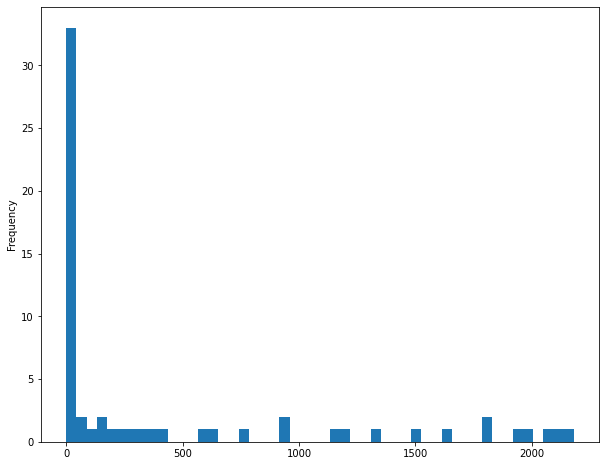

In [8]:
dataDf.title.str.split().str.len().value_counts()\
    .plot(kind = 'hist', bins = 50, figsize = (10,8));

for example:

In [9]:
dataDf.title.iloc[0]

'Discovering human history from stomach bacteria'

each article comes wth an abstract. Below is the overall distribution of the length of the title

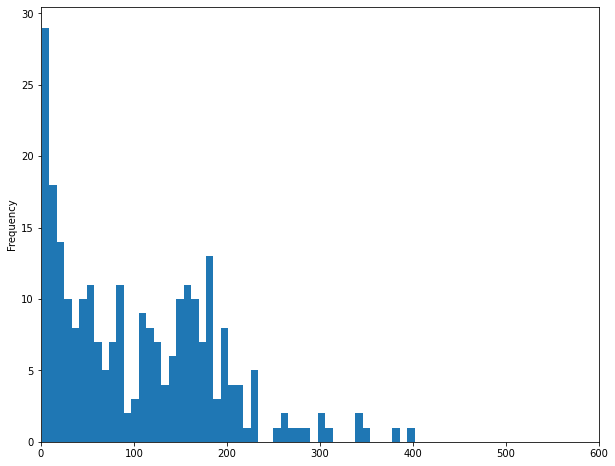

In [10]:
dataDf.abstract.str.split().str.len().value_counts()\
    .plot(kind = 'hist', bins = 50, figsize = (10,8), xlim=(0,600));

for example:

In [11]:
dataDf.abstract.iloc[0]

'Recent analyses of human pathogens have revealed that their evolutionary histories are congruent with the hypothesized pattern of ancient and modern human population migrations. Phylogenetic trees of strains of the bacterium Helicobacter pylori and the polyoma JC virus taken from geographically diverse groups of human beings correlate closely with relationships of the populations in which they are found.'

In the rest of the notebook, we are going to work with a concatenation of both title and abstract. Distribution of the size of text to be processed [title, abstract]:

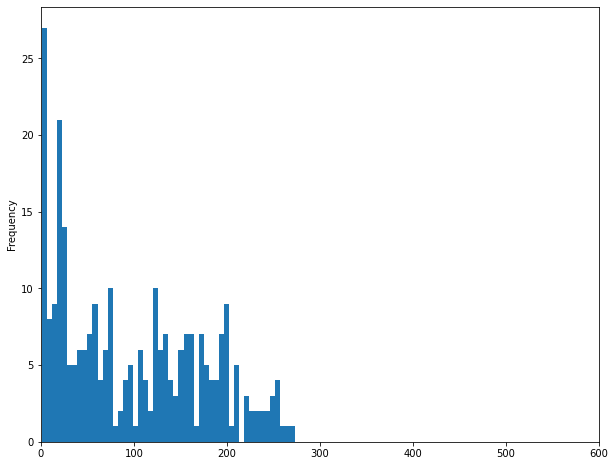

In [12]:
dataDf.text.str.split().str.len().value_counts()\
    .plot(kind = 'hist', bins = 50, figsize = (10,8), xlim=(0,600));

for example:

In [13]:
dataDf.text.iloc[0]

'Discovering human history from stomach bacteria Recent analyses of human pathogens have revealed that their evolutionary histories are congruent with the hypothesized pattern of ancient and modern human population migrations. Phylogenetic trees of strains of the bacterium Helicobacter pylori and the polyoma JC virus taken from geographically diverse groups of human beings correlate closely with relationships of the populations in which they are found.'

# Preprocessing

In [14]:
custom_stop_words = ['abstract', 'preprint', 'fig', 'doi', 'equilibrium', 'spatial', 'eq', 'time' \
                     ,'rainfall', 'hsa', 'susceptible','number', 'biorxiv', 'ape', 'mir', 'bifurcation',\
                     'forecasts', 'parameter', 'using', 'peer', 'reviewed', 'fia', 'lf','medrxiv', 'reuse',\
                     'reserved', 'holder', 'copyright', 'funder', 'author','reviewed', 'peer', 'allowed',\
                     'granted', 'sia','license', 'https', 'org', 'display', 'appendicitis', 'biorxiv',\
                     'respondents', 'nanoparticles', 'filmarray','probnp', 'btv', 'january', 'medrxiv',\
                     'preprint', 'license', 'number', 'granted', 'display', 'estimated', 'doi','days', 'confirmed',\
                     'available', 'cc', 'nd', 'nc', 'author', 'reuse', 'reserved', 'allowed', 'peer', 'reviewed',\
                     'copyright', 'holder','author', 'funder', 'org', 'https', 'et', 'al', 'using', 'fig', 'figure',\
                     'used', 'onset', 'preprint','days', 'time', 'granted', 'mean', 'display', 'number', 'screening',\
                     'exposure', 'ci', 'available', 'travellers', 'estimated','intervals', 'uveitis', 'ii', 'predicted',\
                     'biorxiv', 'jia', 'dr', 'org', 'using', 'selected', 'lamp', 'osd', 'xf', 'medrxiv','sets', 'peer',\
                     'reviewed', 'inactivation', 'preprint', 'prf', 'doi', 'mngs', 'r503', 'https', 'org', 'valent',\
                     'tilorone', 'prepared','inactivated', 'preprint', 'number', 'doi', 'perpetuity', 'available', 'estimated',\
                     'display', 'reported', 'time', 'cc', 'onset', 'days','copyright', 'ax', 'file','preprint', 'perceived',\
                     'bat', 'pangolin', 'ratg13', 'doi', 'preprint', 'org', 'hdl', 'funder', 'reuse', 'allowed','nanopore',\
                     'coverage','datasets', 'reference', 'ont', 'supplementary', 'annotation', 'vadr', 'parhyale', 'abundance',\
                     'mapped', 'expression','cell', 'il', 'data', 'ifitm3', 'perpetuity','display', 'nd', 'nc', 'group',\
                     'admission', 'chickens', 'tree', 'preprint', 'infected', 'time', \
                     'confirmed', 'days', 'pro', 'residues', 'kcal', 'org', 'mol', 'hydrogen', 'reuse']

#lemmatize: change tense to present
#stem: reduce words to their roots
def lemmatize_stemming(text):
    stemmer = stem.PorterStemmer()
    return stemmer.stem(stem.WordNetLemmatizer().lemmatize(text, pos='v'))

#tokenization: split the string into list of words
#remove stop words
def preprocess(text):
    result = []
    if isinstance(text, float) == False:
        for token in gensim.utils.simple_preprocess(text):
            if (token not in gensim.parsing.preprocessing.STOPWORDS) and (token not in custom_stop_words):
                result.append(lemmatize_stemming(token))
    return result


text cleaning steps:
- remove stop words
- remove custom words
- lemmatization: return the base or dictionary form of a word
- stemming: heuristic process that chops off the ends of words

In [15]:
corpus = dataDf['norm_text'] = dataDf['text'].map(preprocess)

create dictionary and remove words that are not frequent at all

In [16]:
dictionary = gensim.corpora.Dictionary(corpus)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

transform corpus into bag of words array
> representation of text that describes the occurrence of words within a document. It involves two things: A vocabulary of known words. A measure of the presence of known words.

In [17]:
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

transform bag of words into tf-idf array
> short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [18]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# Topic modelling

run LDA algoritm
> generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model and belongs to the machine learning toolbox and in wider sense to the artificial intelligence toolbox.

In [19]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
                                             id2word=dictionary,
                                             num_topics=4,
                                             passes=5,
                                             workers=4,
                                             random_state=4)

We print topics and take care of storing what is the index of vaccine related topic.

In [20]:
vaccinTopic = -1
for idx, topic in lda_model_tfidf.print_topics(-1, 20):
    print('\nTopic: {} keywords: {}'.format(idx, topic))
    if 'vaccin' in topic:
        vaccinTopic = idx
print("\n\nindex of topic related to vaccin is {}".format(vaccinTopic))


Topic: 0 keywords: 0.008*"immun" + 0.005*"cell" + 0.005*"ifn" + 0.005*"respons" + 0.005*"infect" + 0.004*"viral" + 0.004*"cd" + 0.004*"lung" + 0.003*"induc" + 0.003*"innat" + 0.003*"diseas" + 0.003*"cytokin" + 0.003*"inflammatori" + 0.003*"host" + 0.003*"la" + 0.003*"mice" + 0.003*"asthma" + 0.003*"viru" + 0.003*"cn" + 0.003*"respiratori"

Topic: 1 keywords: 0.006*"health" + 0.005*"diseas" + 0.005*"covid" + 0.004*"sar" + 0.004*"patient" + 0.004*"emerg" + 0.004*"outbreak" + 0.004*"case" + 0.003*"care" + 0.003*"respiratori" + 0.003*"public" + 0.003*"influenza" + 0.003*"epidem" + 0.003*"infecti" + 0.003*"model" + 0.003*"risk" + 0.003*"pandem" + 0.003*"china" + 0.003*"cov" + 0.003*"infect"

Topic: 2 keywords: 0.006*"antibodi" + 0.005*"viru" + 0.005*"detect" + 0.005*"strain" + 0.004*"cov" + 0.004*"vaccin" + 0.004*"pcr" + 0.004*"assay" + 0.004*"sar" + 0.004*"coronaviru" + 0.003*"sampl" + 0.003*"protein" + 0.003*"cat" + 0.003*"isol" + 0.003*"infect" + 0.003*"recombin" + 0.003*"sequenc" + 0.0

visualize model

In [21]:
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary=dictionary)
pyLDAvis.display(vis)

# LDA filtering: keep documents related to vaccine

add new columns to data frame to place the topic related probability for each article

In [22]:
new_columns = ['lda_dominant']
topics = [('topic_' + str(i)) for i in range(lda_model_tfidf.num_topics)]
new_columns.extend(topics)
dataDf = pd.concat([dataDf, pd.DataFrame(columns=new_columns)], axis=1);

check what topic is dominant in each article

In [23]:
for idx, row in dataDf.iterrows():

    doc = dataDf.loc[idx].norm_text
    bow = dictionary.doc2bow(doc)
    res = lda_model_tfidf.get_document_topics(bow)

    for topic_num, val in res:
        dataDf.loc[idx, topics[topic_num]] = val
    dataDf.loc[idx, 'lda_dominant'] = np.nanargmax(dataDf.loc[idx, topics].values)

from now, we will keep only the documents related to vaccine

In [24]:
vaccinLdaDf = dataDf.loc[dataDf['lda_dominant'] == vaccinTopic]

we reduced the number of articles from 22000 to :

In [25]:
print('number of articles after lda filtering: {}'.format(len(vaccinLdaDf)))

number of articles after lda filtering: 6605


# KNN filtering

We will now split the words into 10 clusters thanks to  k-means algorithm:
> k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.

In [26]:
np.random.seed(0)

#remove empty text
vaccinLdaDf = vaccinLdaDf.loc[vaccinLdaDf['norm_text']!=np.nan]
                
#re-create Tf-Idf vector for sklearn library                    
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(vaccinLdaDf['norm_text'].str.join(' '))

#true_k -> number of clusters
true_k = 10
kmodel = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=5)
kmodel.fit(X)
       
print("Top terms per cluster:")
order_centroids = kmodel.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

kMeansDict = {}
for i in range(true_k):
    kMeansDict[i] = []
    for ind in order_centroids[i, :50]:
        kMeansDict[i].append(terms[ind])
        
kClustersDf =pd.DataFrame.from_records(kMeansDict).add_prefix('cluster_')
kClustersDf

Top terms per cluster:


,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,calv,antibodi,viru,pedv,mer,ace,sar,ibv,pcr,mhv
1,respiratori,vaccin,cat,diarrhea,cov,angiotensin,cov,bronchiti,detect,hepat
2,children,immun,infect,porcin,east,ang,protein,infecti,assay,mice
3,hcov,viru,sequenc,epidem,middl,convert,coronaviru,strain,rt,mous
4,infect,neutral,strain,strain,camel,enzym,syndrom,avian,sensit,viru
5,rotaviru,protein,felin,viru,respiratori,sar,antibodi,viru,method,jhm
6,human,antigen,cell,piglet,syndrom,receptor,acut,sequenc,real,murin
7,detect,protect,isol,pig,coronaviru,ncov,sever,gene,respiratori,strain
8,patient,epitop,coronaviru,china,human,renin,respiratori,vaccin,influenza,cell
9,sampl,mab,virus,sequenc,dromedari,ra,patient,isol,sampl,infect


The PCA algorithm below shows 2D representation of the keywords

/home/niharika/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


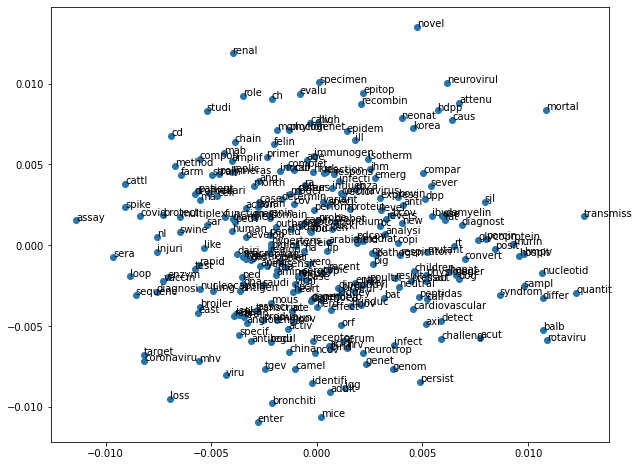

In [27]:
# train model
pcamodel = Word2Vec(kMeansDict.values(), min_count=1)
# fit a 2d PCA model to the vectors
Xvec = pcamodel[pcamodel.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(Xvec)
# create a scatter plot of the projection
fig = pyplot.figure(figsize=(10,8))
pyplot.scatter(result[:, 0], result[:, 1])
words = list(pcamodel.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

identify the clusters related to vaccine and antibodies

In [28]:
cluster = []
for i in range(len(kClustersDf.columns)):
    if kClustersDf.iloc[0,i] in ['vaccin', 'antibodi']:
        cluster.append(i)
print("we should keep cluster {} as it relates to vaccin".format(cluster))

we should keep cluster [1] as it relates to vaccin


filter documents related to vaccine and antibodies

In [29]:
vaccinLdaDf['cluster'] = kmodel.predict(X)
vaccinLdaKnnDf = vaccinLdaDf[vaccinLdaDf['cluster'].isin(cluster)]

we reduced the number of articles from 22000 to :

In [38]:
print('number of articles after lda and knn filtering: {}'.format(len(vaccinLdaKnnDf)))

number of articles after lda and knn filtering: 1015
